## Population dynamic models

An example of a population dynamic model that recently got a lot of attention are SIR models of the spread of a pathogen (for example SARS-CoV-2) in a population. They model how individuals that are initially susceptible, become infected and infect more, before recovering. 

Predator-prey models are simple model of ecology which are conceptually very similar to SIR models. A predator species grows when there is a lot of prey around, if it exhausts the prey, the predator population collapses and the prey recovers. 

### Susceptible-Infected-Recovered (SIR-) models

![image.png](figures/SIR_sketch.png)

This SIR model is described by the following set of differential equations describing the fraction of the population that are susceptible $S$, infectious $I$ or recovered ($R$):

$$
\begin{split}
\frac{dS(t)}{dt} &= -\beta S(t)I(t) + \delta R =  -\beta S(t)I(t) + \delta (1-S-I)\\
\frac{dI(t)}{dt} &= \beta S(t)I(t) - \nu I(t) \\
\frac{dR(t)}{dt} & = \nu I(t) - \delta R
\end{split}
$$

We don't actually need an additional equation for $R$ since $R = 1-S-I$. The quantity $\beta$ is the rate at which an people are infected in encouters between susceptible and infectious people, which is proportional to $S(t)I(t)$, while $\nu$ is the rate at which infectious people recover. 

You will have heard a lot about the quantity $R_0$ which describes how many people an infectious person infects on average. This quantity can be expressed in terms of $\beta$ and $\nu$ as

$$
R_0 = \frac{\beta}{\nu}
$$

Note that this is _system_ of differential equations. There are two quantities for which the equations describe the rate at which they change. And these two equations are coupled, that is they depend on each other in a non-linear way (the term $\beta S(t)I(t)$. Such systems can rarely be solved analytically. But we can tackle them by two approaches:

 * approximate specific limits, for example the limit $S \approx 1$ and $I\ll 1$.
 * solve them numerically

### Approximate solution in the early epidemic
Assume a population that is entirely susceptible to a disease $S(t)=1-1/N$ and a single individual is infected $I(0) = 1/N$. If $N$ is very big, the outbreak will initially not make much of a difference for $S(t)$ which stays close to $1$. If we hence ignore the first equation and assume $S\approx 1$ for the second, we get

$$
\frac{dI(t)}{dt} \approx (\beta - \nu) I(t) = \nu (R_0 - 1) I(t)
$$

We have seen this equation before: it is simply exponential growth with a growth rate $\beta - \nu$. If $\beta > \nu$, the outbreak grows ($R_0>1$), while the outbreak shrinks for $\beta <\nu$ ($R_0<1$).

The initial solution of this equation is 
$$
I(t) \approx I(0) e^{\nu(R_0-1)t}
$$


However, this approximate solution will not describe the behavior once the outbreak is large. To understand this, we need to solve it numerically. 

### Numerical solution using the ODE solver from scipy

instead of using our simple "step-by-step" (see below for a version using forward Euler) solution of the ODE, we will now use the a dedicated solver from the scientific computing package scipy to solve the ODE. This solver is works for all sorts of problems with one, two, three, or more variables. To be that general, the solver requires the function to be solved to be provided in a particular way. The definition of the function needs to accept arguments as follows

 - a vector (numpy array) that contains the state. One number of each variable y = [y_1, y_2, y_3, ...]
 - the time (even if the problem doesn't depend on time
 - all other parameter
 
The function needs to return a vector containing the derivative of each of the variables. [dy_1/dt, dy_2/dt, ...]


In [1]:
# define a function that returns the derivative of S and I. Note that y = [S,I]
def derivative(y, t, beta, nu, delta):
    S, I = y   # y is a vector with values [S, I]
    dSdt = -beta*S*I + delta*(1-S-I)
    dIdt = beta*S*I - nu*I
    return [dSdt, dIdt]

In [2]:
import numpy as np
from scipy.integrate import odeint

I0 = 1e-6
S0 = 1 - I0
nu = 1/3 # recovery after 3 days
delta = 1/180  # susceptible again after 180days
R_0 = 2  # average number of infections per individual
beta = R_0*nu # one infection per day per contact
T = np.linspace(0,1000,1001) # time points for which we want to solve the equation

# solve it!
sol = odeint(derivative, [S0, I0], T, (beta, nu, delta))


This returns a solution in shape of a matrix where columns corresponds to the variables y_1, y_2, ... (S, I in our case) and each row corresponds to one timepoint from the vector T.

In [3]:
sol[:5,:]

array([[9.99999000e-01, 1.00000000e-06],
       [9.99998203e-01, 1.39911620e-06],
       [9.99997105e-01, 1.94990401e-06],
       [9.99995539e-01, 2.73679560e-06],
       [9.99993389e-01, 3.81764424e-06]])

Final susceptible population: 0.50
0.695=1.001


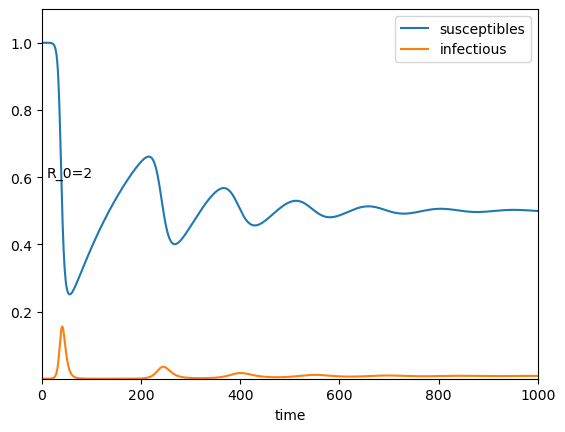

In [4]:
import matplotlib.pyplot as plt

plt.plot(T, sol[:,0], label='susceptibles')
plt.plot(T, sol[:,1], label='infectious')
plt.text(10,0.6, f"R_0={R_0}")
#plt.plot(T, I0*np.exp((beta-nu)*T), ls='--', label='initial approximation')
plt.xlim([0,1000])
plt.ylim([0,1.1])
plt.ylim([I0,1.1])
plt.xlabel('time')
#plt.yscale('log')
plt.legend()
# see how many people remain 6susceptible after the outbreak. This is the last element of 'sol' 'sol[-1]'
print(f"Final susceptible population: {sol[-1,0]:1.2f}")
print(f"{-np.log(sol[-1,0]):1.3f}={R_0*(1-sol[-1,0]):1.3f}")
plt.savefig('SIR_overshoot.png')

There are two important messages here:
 * solving a system of non-linear ODEs works just the same as a one-dimensional one
 * Approximate solutions in some parts of the range can be very accurate

#### Equivalent solution using forward Euler

Text(0.5, 0, 'time')

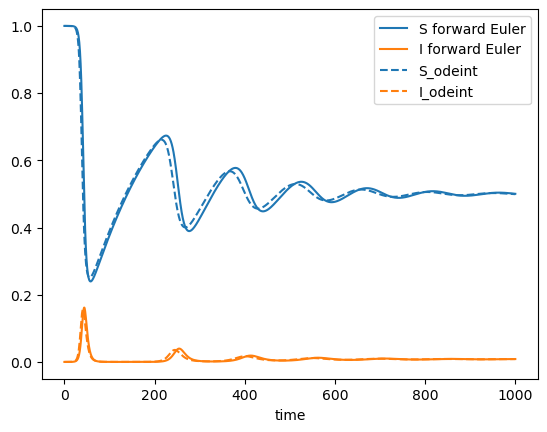

In [5]:
def derivative_ForwardEuler(S,I,beta,nu,delta):
    dSdt = -beta*S*I + delta*(1-S-I)
    dIdt = beta*S*I - nu*I
    return [dSdt, dIdt]

t0 = 0
tmax=1000
dt = .5

Svec = [S0]
Ivec = [I0]
tvec = [t0]
t = t0
S = S0
I = I0

while t<tmax:
    dSdt, dIdt = derivative_ForwardEuler(S,I, beta, nu, delta)
    S += dt*dSdt
    I += dt*dIdt
    t += dt
    Svec.append(S)
    Ivec.append(I)
    tvec.append(t)

plt.plot(tvec, Svec, label='S forward Euler')
plt.plot(tvec, Ivec, label='I forward Euler')
plt.plot(T, sol[:,0], label='S_odeint', ls='--', c='C0')
plt.plot(T, sol[:,1], label='I_odeint', ls='--', c='C1')
plt.legend()
plt.xlabel('time')

## Lotka-Voltera models

Lets consider the prey species with population $x$ and a predator species with population $y$. 
$$
\frac{dx}{dt} = -\beta xy + \alpha x \\
$$$$
\frac{dy}{dt} = \beta xy - \gamma y \\
$$
Here $\alpha$ is the growth rate of the prey in absence of predation, $\beta$ is the predation rate per prey-predator encounter, $\gamma$ is the death rate of predators without food.

We can solve this system numerically analogously to what we did for the SIR model.

In [6]:
def derivative_LV(P, t, alpha, beta, gamma):
    x,y = P   # P is a vector with values [x, y]
    dxdt = -beta*x*y + alpha*x
    dydt = beta*x*y - gamma*y
    return [dxdt, dydt]

In [7]:
x0 = 10    # initial population of prey
y0 = 1     # initial population of predator
gamma = 1/2 # predator dying in 2 weeks
alpha = 1   # growth rate of prey population in units per week
beta = 0.01 # predation rate 0.01
T = np.linspace(0,100,1001)
sol = odeint(derivative_LV, [x0, y0], T, (alpha, beta, gamma))

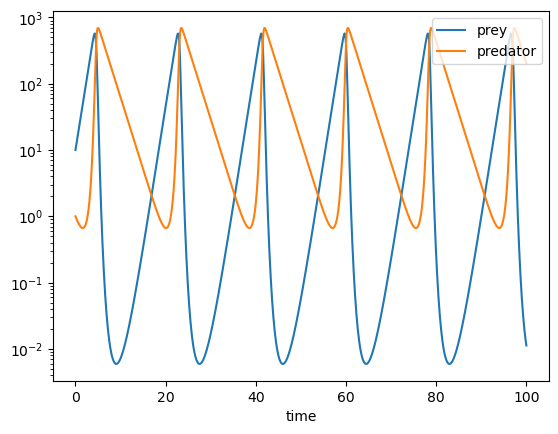

In [8]:
plt.plot(T, sol[:,0], label='prey')
plt.plot(T, sol[:,1], label='predator')
plt.xlabel('time')
plt.legend(loc=1)
plt.yscale('log')

Text(0, 0.5, 'predator')

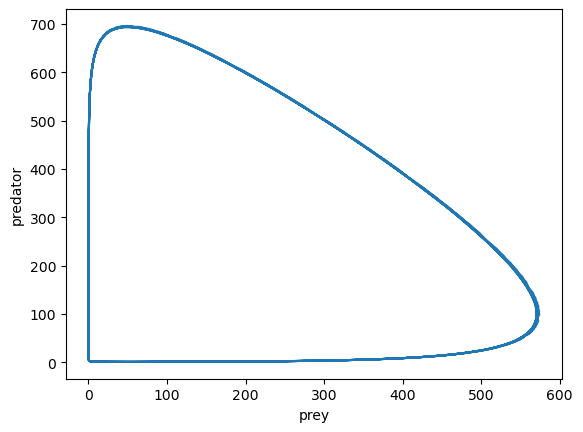

In [9]:
# plot of the limit cycle in the phase plan of predator and prey
plt.plot(sol[:,0], sol[:,1])
plt.xlabel('prey')
plt.ylabel('predator')



#### Dig deeper
 * change the parameters of the model ($R_0$) and observe how the fraction of individuals that remain susceptible at the end of the outbreak changes. 
 * automate the process of changing $R_0$ and plot the remaining number of susceptible against $R_0$.
 * explore the behavior of the outbreak as you change the initial value $S_0$ of $S$. What happens when $S_0 < 1/R_0$? How does this "herd immunity" threshold compare to the remaining number of susceptible individuals after the outbreak?
 * include a an additional state of "exposed" individuals that describes individuals during their incubation time. These models are called [Susceptible-Exposed-Infectious-Recovered-models (SEIR models)](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model)